# Removing fragments from simulation data

## Outline

1. [Starting point](#starting_point)
2. [Volume-of-fluid data](#vof_data)
3. [Parameterization](#parameterization)
4. [Simple function approximation](#function_approximation)
5. [Direct approximation of the radius](#direct_approximation)
6. [Using prior/domain knowledge](#prior_knowledge)
    1. [Re-scaling the data](#rescaling)
    2. [Adding artificial data](#artificial_data)
    3. [Creating ensemble models](#ensemble_models)
7. [Final notes](#final_notes)

## Starting point<a id="starting_point"></a>

- detect and remove fragments
- show image of bubble and fragments

In [165]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn as sk
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    import urllib
    import cloudpickle as cp
else:
    import pickle
    matplotlib.rcParams['figure.dpi'] = 80

print("Pandas version: {}".format(pd.__version__))
print("Numpy version: {}".format(np.__version__))
print("Sklearn version: {}".format(sk.__version__))
print("Running notebook {}".format("in colab." if IN_COLAB else "locally."))

Pandas version: 0.24.2
Numpy version: 1.14.2
Sklearn version: 0.19.1
Running notebook locally.


In [44]:
if not IN_COLAB:
    data_file = "../data/7mm_water_air_plic.pkl"
    with open(data_file, 'rb') as file:
        data = pickle.load(file).drop(["element"], axis=1)
else:
    data_file = "https://github.com/AndreWeiner/machine-learning-applied-to-cfd/blob/master/data/7mm_water_air_plic.pkl?raw=true"
    response = urllib.request.urlopen(data_file)
    data = cp.load(response).drop(["element"], axis=1)

print("The data set contains {} points.".format(data.shape[0]))
data.sample(5)

The data set contains 120130 points.


,px,py,pz
111245,0.347803,90.952103,-0.629883
94187,0.307617,90.922897,-0.785402
55253,-0.791016,91.508797,-0.692248
71826,-0.029297,91.024902,-0.161133
71546,-0.114608,91.010696,-0.205078


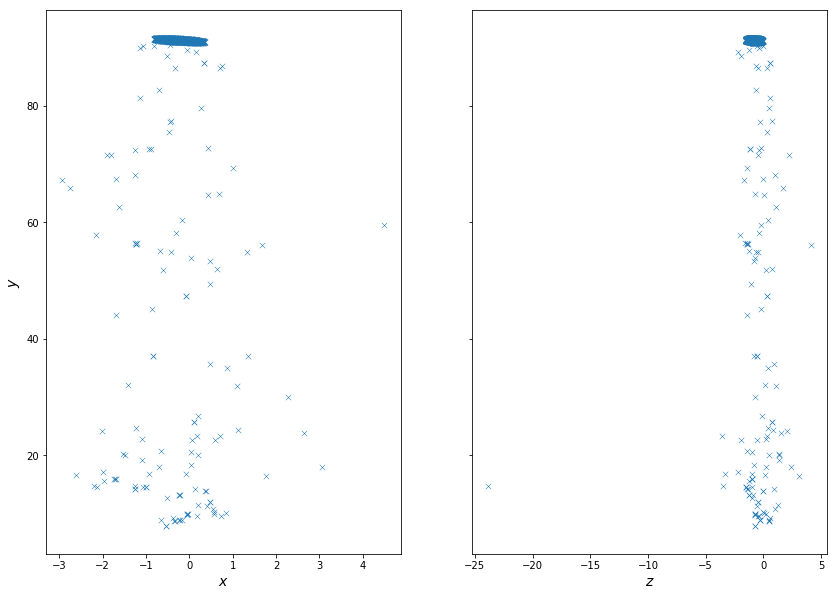

In [160]:
%matplotlib inline
every = 100
fontsize = 14

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10), sharey=True)

ax1.scatter(data.px.values[::every], data.py.values[::every],
            marker='x', color='C0', s=30, linewidth=0.5)
ax2.scatter(data.pz.values[::every], data.py.values[::every],
            marker='x', color='C0', s=30, linewidth=0.5)

ax1.set_xlabel(r"$x$", fontsize=fontsize)
ax1.set_ylabel(r"$y$", fontsize=fontsize)
ax2.set_xlabel(r"$z$", fontsize=fontsize)

plt.show()

In [103]:
from sklearn.ensemble import IsolationForest

def fit_isolation_forest(contamination):
    clf = IsolationForest(n_estimators=100, contamination=contamination)
    return clf.fit(data[['px', 'py', 'pz']].values).predict(data[['px', 'py', 'pz']].values)

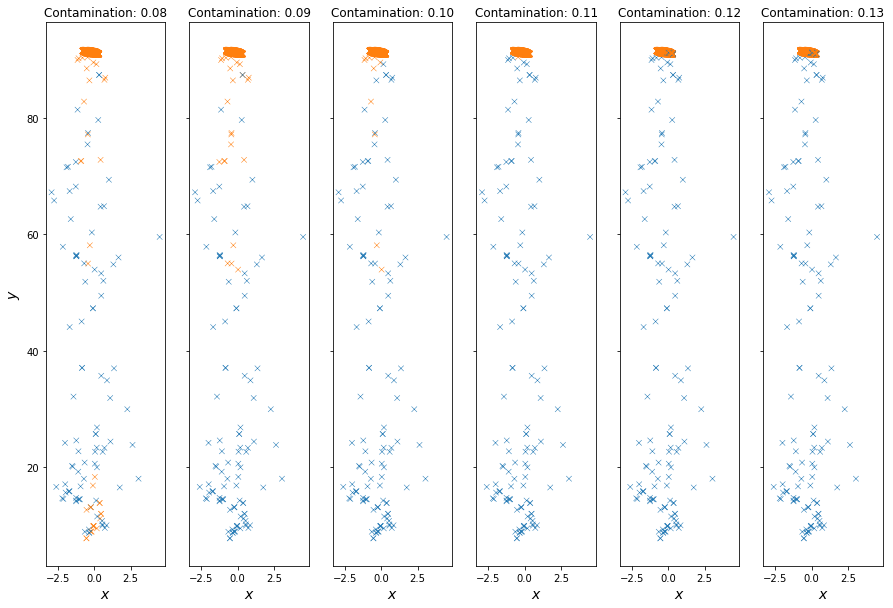

In [110]:
fig, axarr = plt.subplots(1, 6, figsize=(15, 10), sharey=True)

colors = np.array(['C0', 'C1'])

for i, cont in enumerate(np.arange(0.08, 0.135, 0.01)):
    pred = fit_isolation_forest(cont)
    axarr[i].scatter(data.px.values[::every], data.py.values[::every],
                     marker='x', color=colors[(pred[::every] + 1) // 2], s=30, linewidth=0.5)
    axarr[i].set_title("Contamination: {:2.2f}".format(cont))
    axarr[i].set_xlabel(r"$x$", fontsize=fontsize)

axarr[0].set_ylabel(r"$y$", fontsize=fontsize)
plt.show()

In [161]:
clf = IsolationForest(n_estimators=200, contamination=0.11)
pred = clf.fit(data[['px', 'py', 'pz']].values).predict(data[['px', 'py', 'pz']].values)

In [162]:
points_clean = data[['px', 'py', 'pz']].values[pred > 0]
print("Removed {} points from data set.".format(data.shape[0] - points_clean.shape[0]))

Removed 13216 points from data set.


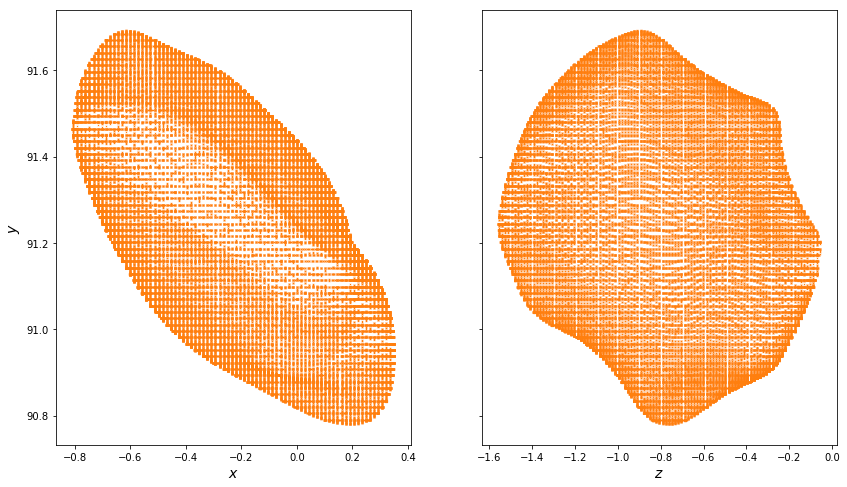

In [163]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

ax1.scatter(points_clean[:,0], points_clean[:,1],
            marker='x', color='C1', s=2, linewidth=0.5)
ax2.scatter(points_clean[:,2], points_clean[:,1],
            marker='x', color='C1', s=2, linewidth=0.5)

ax1.set_xlabel(r"$x$", fontsize=fontsize)
ax1.set_ylabel(r"$y$", fontsize=fontsize)
ax2.set_xlabel(r"$z$", fontsize=fontsize)

plt.show()

<IPython.core.display.Javascript object>


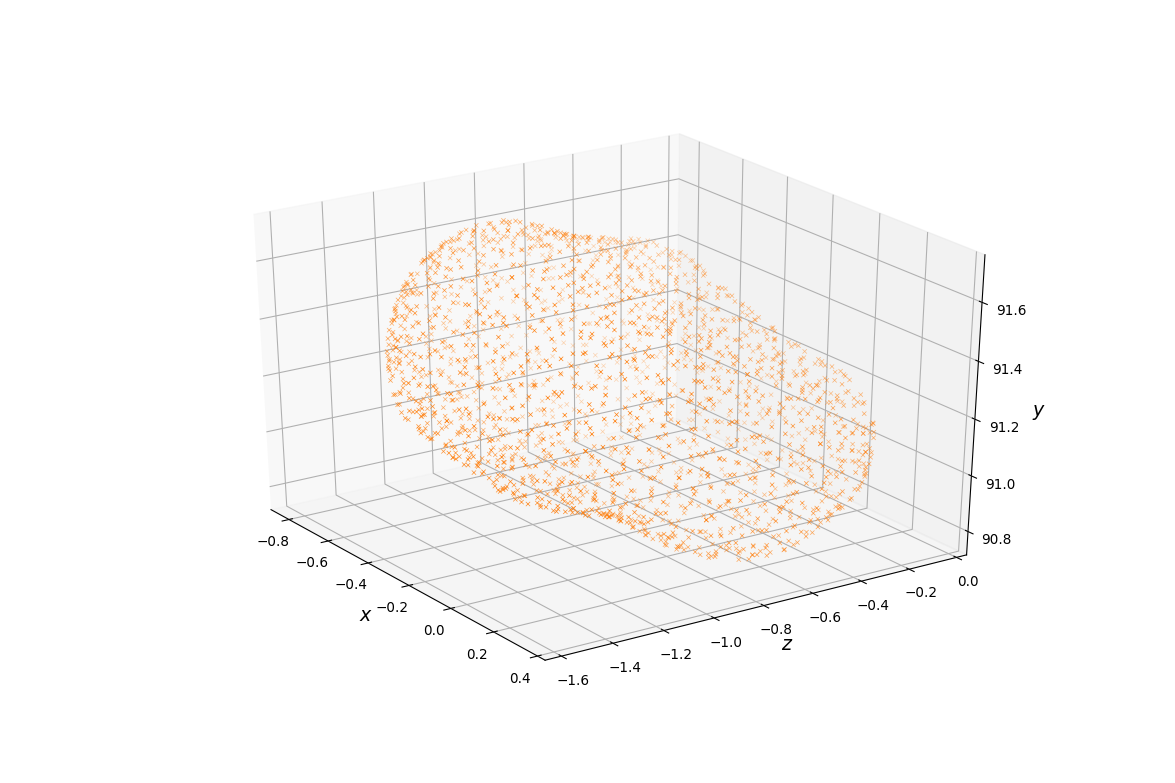

In [167]:
if IN_COLAB:
    %matplotlib inline
else:
    %matplotlib notebook
    
every = 50

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points_clean[:,0][::every], points_clean[:,2][::every], points_clean[:,1][::every],
            marker='x', color='C1', s=10, linewidth=0.5)

ax.set_xlabel(r"$x$", fontsize=fontsize)
ax.set_ylabel(r"$z$", fontsize=fontsize)
ax.set_zlabel(r"$y$", fontsize=fontsize)
plt.show()